In [1]:
import numpy as np # array operations
import pandas as pd # dataframe operations
from scipy.stats import norm

# plotting
import matplotlib.pyplot as plt 
from matplotlib.ticker import (MultipleLocator,FormatStrFormatter,AutoMinorLocator)
from mpl_toolkits.mplot3d import Axes3D

# Machine learning related functions
from sklearn.preprocessing import StandardScaler #normalizing inputs
from sklearn.decomposition import PCA  # principal component analysis
from sklearn.gaussian_process import GaussianProcessRegressor 
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from tqdm.auto import tqdm #progress bar 
from warnings import filterwarnings #disable warnings
filterwarnings('ignore')
from IPython import display 
%matplotlib inline

In [2]:
from google.colab import files
uploaded = files.upload()

Saving Yield_dataset_cleaned.csv to Yield_dataset_cleaned.csv




## Data preprocessing

In [ ]:
# mount drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
# reading the data
df = pd.read_csv('Yield_dataset_cleaned.csv', sep=",")
df['Catalyst'] = df['Catalyst ']
#df= df.drop(columns=['Catalyst ','Time (min)','V(pore) (cm3/g)'])
df= df.drop(columns=['Catalyst '])
pd.set_option("display.max_rows", None, "display.max_columns", None)

In [ ]:
# removing DMSO from the dataset (outliers)
df_3 =df.loc[df['phase_2']=='DMSO']
df_4 =df.loc[df['phase_1']=='DMSO']
print(df_3.shape,df_4.shape)
df = df[df.phase_2 !='DMSO']
df = df[df.phase_1 !='DMSO']

(16, 28) (0, 28)


In [ ]:
#Handling typos
df.loc[df['Type of catalyst'] =='Transition Metal Zolite','Type of catalyst'] = 'Transition Metal Zeolite'
df.loc[df['Type of catalyst'] =='Protonated Zeolites','Type of catalyst'] = 'Protonated Zeolite'
df.loc[df['Substrate'] =='Fructose ','Substrate'] = 'Fructose'
df.loc[df['Solvent system'] =='Single Phase','Solvent system'] = 'Single phase'
df.loc[df['Solvent system'] =='Biphasic ','Solvent system'] = 'Biphasic'
df.loc[df['phase_1'] =='water','phase_1'] = 'Water'
df.loc[df['phase_1'] =='Water ','phase_1'] = 'Water'
df.loc[df['phase_1'] =='THF ','phase_1'] = 'THF'
df.loc[df['phase_2'] =='THF ','phase_2'] = 'THF'

In [ ]:
#handling Nan
df['phase_2'] = df['phase_2'].fillna("one_phase")
for i in ['Surface area (m2/g) BET','V(mic) (cm3/g)','TPD (NH3) (micmol/g)','V(pore) (cm3/g)']:
    df[i] = df[i].fillna(df.groupby('Catalyst')[i].transform('mean'))

In [ ]:
df =df.loc[df['Substrate']=='Fructose']
# remove mesopore vol because of high correlation
df = df.drop(columns=['Substrate','M/Al (ie Sn, Cu..)','Lewis/Brosnted  acid Sites','Flow/Batch','Heating'])
df = df[df['Si/Al'].notna()]

In [ ]:
df.shape

(108, 23)

In [ ]:
df['Catalyst'] = df['Catalyst'].astype('category')
cat_dict =dict(enumerate(df['Catalyst'].cat.categories ))

In [ ]:
#label encoding
for i in ['Type of catalyst','Catalyst','Solvent system','phase_1','phase_2']:
    df[i] = df[i].astype('category')
    df[i] = df[i].cat.codes
df.dtypes

Type of catalyst                   int8
Si/Al                           float64
Surface area (m2/g) BET         float64
Avg_pore_diameter(nm)           float64
V(pore) (cm3/g)                 float64
V(mic) (cm3/g)                  float64
V(mesopore) (cm3/g)             float64
TPD (NH3) (micmol/g)            float64
Catalyst/Substrate loading\n    float64
Solvent system                     int8
phase_1                            int8
phase_2                            int8
phase_2/phase_1                 float64
organic solvent                   int64
Total dipole moment(D)          float64
Organic dipole                  float64
Temperature ( °C)                 int64
Time (min)                        int64
HMF Yield                       float64
Fructose Conversion             float64
HMF Selectivity                 float64
Unnamed: 27                     float64
Catalyst                           int8
dtype: object

In [4]:
#df= df.drop(columns=['Type of catalyst','Solvent system','phase_1','phase_2','Catalyst','organic solvent','Organic dipole','Time (min)','V(mesopore) (cm3/g)'])
df= df.drop(columns=['organic solvent','Organic dipole','Time (min)','V(mesopore) (cm3/g)','Type of catalyst','Catalyst','Fructose Conversion','HMF Selectivity','Unnamed: 27'])

In [ ]:
# based on feature importance: 
#df = df.drop(columns=['inorganic solvent','Surface area (m2/g) BET','Type of catalyst','Catalyst','V(mesopore) (cm3/g)','V(pore) (cm3/g)','V(mic) (cm3/g)'])
#df_2 = df[df['V(pore) (cm3/g)'].isna()]
df = df.dropna()
#df = df.fillna(df.mean())  
df.shape

(103, 14)

In [ ]:
# figure(figsize=(18, 8), dpi=120)
# plt.plot(df['Catalyst'],df['TPD (NH3) (micmol/g)'],'o')
# positions = (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12)
# labels = ('Al-SBA15', 'BEA(modified) ', 'H-BEA', 'H-MCM-22', 'H-MOR', 'H-USY', 'H-ZSM-5', 'KL', 'KL (modified) *', 'USY (modified) ', 'USY (modified) *', 'ZSM-5 (modified)', 'ZSM-5 (modified) *')
# plt.xticks(positions, labels)
# plt.show()

In [ ]:
df.describe()

,Si/Al,Surface area (m2/g) BET,Avg_pore_diameter(nm),V(pore) (cm3/g),V(mic) (cm3/g),TPD (NH3) (micmol/g),Catalyst/Substrate loading\n,Solvent system,phase_1,phase_2,phase_2/phase_1,Total dipole moment(D),Temperature ( °C),HMF Yield
count,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000
mean,23.527282,623.868551,0.656602,0.405317,0.204961,682.672350,0.369027,0.378641,0.592233,10.815534,22.508091,2.960323,151.067961,25.933759
std,19.356391,189.364672,0.073131,0.174966,0.061227,399.432041,0.282209,0.487420,0.797507,4.545516,38.346995,1.640932,16.769055,19.496235
min,2.600000,299.000000,0.550000,0.178000,0.090780,120.000000,0.100000,0.000000,-1.000000,0.000000,0.000000,0.450000,100.000000,0.240000
25%,12.250000,482.714286,0.590000,0.300000,0.154880,328.000000,0.200000,0.000000,1.000000,8.500000,1.000000,1.850000,150.000000,9.850000
50%,15.600000,528.000000,0.670000,0.352000,0.198500,580.000000,0.285714,0.000000,1.000000,10.000000,5.000000,2.641667,160.000000,20.000000
75%,26.635000,780.000000,0.740000,0.537600,0.270000,923.000000,0.400000,1.000000,1.000000,12.500000,10.000000,3.425000,165.000000,40.135000
max,103.000000,1219.000000,0.740000,1.301000,0.359000,1603.000000,1.333333,1.000000,1.000000,18.000000,100.000000,10.295000,195.000000,81.134200


# Random Forest model

In [ ]:
# features = df.drop(columns = ['HMF Yield']).values
# feature_list = list(df.drop(columns = ['HMF Yield']).columns)
# labels = df['HMF Yield'].values

In [ ]:
df =df.drop(columns=['phase_1', 'phase_2'])

In [ ]:
# #Removing outliers
# import scipy.stats as stats
# z_scores = stats.zscore(features)
# abs_z_scores = np.abs(z_scores)
# filtered_entries = (abs_z_scores < 4).all(axis=1)
# df = df[filtered_entries]

In [ ]:
df.shape

(103, 12)

In [ ]:
features = df.drop(columns = ['HMF Yield']).values
feature_list = list(df.drop(columns = ['HMF Yield']).columns)
labels = df['HMF Yield'].values

In [ ]:
# import pandas as pd
# from sklearn import preprocessing
# min_max_scaler = preprocessing.MinMaxScaler()
# features = min_max_scaler.fit_transform(features)

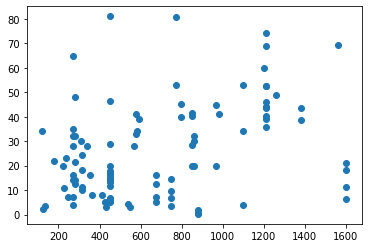

In [ ]:
plt.plot(df['TPD (NH3) (micmol/g)'],df['HMF Yield'],'o')

In [ ]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split
# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.2, random_state = 50)

In [ ]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (82, 11)
Training Labels Shape: (82,)
Testing Features Shape: (21, 11)
Testing Labels Shape: (21,)


In [ ]:
# The baseline predictions are the historical averages
baseline_preds = np.mean(test_labels)
# Baseline errors, and display average baseline error
baseline_errors = abs(baseline_preds - test_labels)
print('Average baseline error: ', round(np.mean(baseline_errors), 2))

Average baseline error:  14.93


## Random hyperparameter search

In [ ]:
# use random research to find the best hyperparameters for RF
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(features, labels)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   39.9s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  5.2min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

In [ ]:
rf_random.best_estimator_

RandomForestRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                      max_depth=30, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=4,
                      min_samples_split=5, min_weight_fraction_leaf=0.0,
                      n_estimators=1000, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [ ]:
base_model = RandomForestRegressor(n_estimators = 100, random_state = 50)
base_model.fit(train_features, train_labels)
base_accuracy = base_model.score(test_features, test_labels)

In [ ]:
best_random = rf_random.best_estimator_

In [ ]:
best_random.fit(train_features, train_labels)
random_accuracy = best_random.score(test_features, test_labels)

## Evaluation

In [ ]:
print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

Improvement of 2.26%.


In [ ]:
rf  = best_random
rf.fit(train_features, train_labels);

In [ ]:
# rf.fit(features, labels)

In [ ]:
rf.score(train_features, train_labels)

0.668668198710771

In [ ]:
rf.score(test_features, test_labels)

0.35435590921068083

In [ ]:
df.columns

Index(['Si/Al', 'Surface area (m2/g) BET', 'Avg_pore_diameter(nm)',
       'V(pore) (cm3/g)', 'V(mic) (cm3/g)', 'TPD (NH3) (micmol/g)',
       'Catalyst/Substrate loading\n', 'Solvent system', 'phase_2/phase_1',
       'Total dipole moment(D)', 'Temperature ( °C)', 'HMF Yield'],
      dtype='object')

In [ ]:
x = np.array([20,400,0.55,0.3,0.22,1000,0.33,1, 5.000000,2.46, 170])
rf.predict(x.reshape(1,-1))

array([28.6])

In [ ]:
df.columns

Index(['Si/Al', 'Surface area (m2/g) BET', 'Avg_pore_diameter(nm)',
       'V(pore) (cm3/g)', 'V(mic) (cm3/g)', 'TPD (NH3) (micmol/g)',
       'Catalyst/Substrate loading\n', 'phase_2/phase_1',
       'Total dipole moment(D)', 'Temperature ( °C)', 'HMF Yield'],
      dtype='object')

In [ ]:
# mount drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Use the forest's predict method on the test data
train_pred = rf.predict(train_features)
# Use the forest's predict method on the test data
predictions = rf.predict(test_features)
# Calculate the absolute errors
errors_train = (train_pred - train_labels)**2
errors = (predictions - test_labels)**2
# Print out the mean absolute error (mae)
print('Mean Absolute Error(train):', round(np.sqrt(np.mean(errors_train)), 2), 'degrees.')
print('Mean Absolute Error(test):', round(np.sqrt(np.mean(errors)), 2), 'degrees.')

Mean Absolute Error(train): 11.12 degrees.
Mean Absolute Error(test): 11.94 degrees.


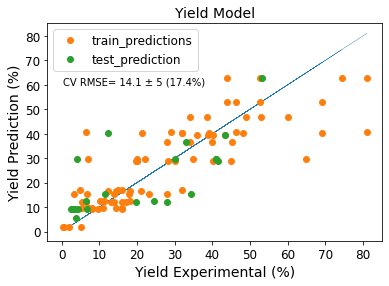

In [ ]:
plt.plot(train_labels, train_labels, '-',linewidth=0.2,color = '#1f77b4')
plt.plot(train_labels,train_pred , 'o',color = '#ff7f0e', label='train_predictions')
plt.plot(test_labels,predictions , 'o',color = '#2ca02c', label ='test_prediction')
plt.text(min(train_labels) , max(train_labels) - 21,'CV RMSE= 14.1 ± 5 (17.4%)')
plt.style.use('seaborn-pastel')

plt.title('Yield Model', fontsize= 14)
plt.xlabel('Yield Experimental (%)', fontsize= 14)
plt.ylabel('Yield Prediction (%)',fontsize= 14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
images_dir = '/content/gdrive/My Drive'
plt.savefig(f"{images_dir}/test_yield_final.png", bbox_inches='tight', dpi = 160)

## Feature importance

In [ ]:
from sklearn.feature_selection import SelectFromModel
model = SelectFromModel(rf, prefit= True)

In [ ]:
# Get numerical feature importances
importances = list(base_model.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: TPD (NH3) (micmol/g) Importance: 0.25
Variable: Total dipole moment(D) Importance: 0.21
Variable: Temperature ( °C)    Importance: 0.2
Variable: phase_2/phase_1      Importance: 0.12
Variable: Si/Al                Importance: 0.06
Variable: Surface area (m2/g) BET Importance: 0.05
Variable: Catalyst/Substrate loading
 Importance: 0.04
Variable: V(mic) (cm3/g)       Importance: 0.03
Variable: Avg_pore_diameter(nm) Importance: 0.02
Variable: V(pore) (cm3/g)      Importance: 0.02


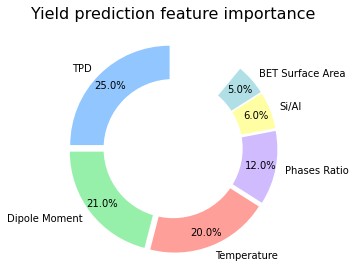

In [ ]:
labels= ["TPD",  "Dipole Moment", "Temperature", "Phases Ratio",  "Si/Al", "BET Surface Area"]
sizes = [0.25,0.21,0.2,0.12,0.06,0.05]
#colors
#colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']
#explsion
explode = (0.05,0.05,0.05,0.05, 0.05,0.05)
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, pctdistance=0.85, explode = explode)
plt.title("Yield prediction feature importance", size = 16)
#draw circle
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.patch.set_facecolor('white')
fig.gca().add_artist(centre_circle)
# Equal aspect ratio ensures that pie is drawn as a circle
#ax1.axis('equal')  
plt.tight_layout()
images_dir = '/content/gdrive/My Drive'
plt.savefig(f"{images_dir}/feature_importance_3.png", dpi = 160)

# Outliers Detection 

In [ ]:
# # identifying and removing outliers
# for i, j in zip(errors_train,train_labels):
#     if i>=20 : 
#         print( 'outlier yield is {:.2f}'.format(j))
#         df = df[df['HMF Yield'] !=j]       
# print(df.shape)

# K-Fold 

In [ ]:
# New random forest with only the two most important variables
model = best_random
df_2 = df.drop(columns = ['HMF Yield'])
df_2=(df_2-df_2.mean())/df_2.std()
features = df_2.values
feature_list = list(df.drop(columns = ['HMF Yield']).columns)
labels = df['HMF Yield'].values
X  = features
y = labels
cv = KFold(n_splits=5, random_state=1, shuffle=True)
scores = cross_val_score(model, X, y, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)
# report performance
print('MAE: %.3f (%.3f)' % (np.abs(mean(scores)), std(scores)))
#print('accuracy %.3f (%.3f)' % (np.abs(mean(model.score)), std(scores)))

MAE: 14.714 (2.531)


In [ ]:
# spanning range scaled error
range = np.max(labels)-np.min(labels)
print("scaled error: %.1f" % (np.abs(mean(scores))/range*100),"%")

scaled error: 18.2 %


# XGB

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, ensemble
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import mean_absolute_error

In [ ]:
from sklearn.model_selection import train_test_split
X  = features
y = labels
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.2, random_state=42)

In [ ]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [ ]:
# # "Learn" the mean from the training data
# mean_train = np.mean(y_train)
# # Get predictions on the test set
# baseline_predictions = np.ones(y_test.shape) * mean_train
# # Compute MAE
# mae_baseline = mean_absolute_error(y_test, baseline_predictions)
# print("Baseline MAE is {:.2f}".format(mae_baseline))

Baseline MAE is 16.90


In [ ]:
params = {
    # Parameters that we are going to tune.
    'max_depth':6,
    'min_child_weight': 1,
    'eta':.3,
    'subsample': 1,
    'colsample_bytree': 1,
    # Other parameters
    'objective':'reg:linear',
    
}

In [ ]:
params['eval_metric'] = "rmse"
num_boost_round = 999

In [ ]:
model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")],
    early_stopping_rounds=5,
)

[17:44:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	Test-rmse:27.0108
Will train until Test-rmse hasn't improved in 5 rounds.
[1]	Test-rmse:22.79
[2]	Test-rmse:20.139
[3]	Test-rmse:18.1078
[4]	Test-rmse:16.5327
[5]	Test-rmse:16.425
[6]	Test-rmse:15.7036
[7]	Test-rmse:16.1143
[8]	Test-rmse:16.0772
[9]	Test-rmse:16.7325
[10]	Test-rmse:17.0107
[11]	Test-rmse:17.4504
Stopping. Best iteration:
[6]	Test-rmse:15.7036



# K-Fold

In [ ]:
dtrain_full = xgb.DMatrix(features, label=labels)

In [ ]:
cv_results = xgb.cv(
    params,
    dtrain_full,
    num_boost_round=num_boost_round,
    seed=42,
    nfold=5,
    metrics={'rmse'},
    early_stopping_rounds=15
)
cv_results

[17:44:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:44:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:44:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:44:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:44:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,24.387408,0.726807,24.533344,3.328579
1,19.105369,0.790591,20.168034,3.628858
2,15.401000,0.822748,17.611794,3.459064
3,12.719746,0.906597,16.124206,3.174009
4,10.805109,1.017310,15.171125,3.068299
5,9.223178,1.080025,14.670818,3.110669
6,8.090905,1.167853,14.201674,3.155755
7,7.217172,1.217612,14.158894,3.153505
8,6.553488,1.267286,14.088585,3.079831
9,6.047449,1.303338,14.080380,3.237543


In [ ]:
# spanning range scaled error
range = np.max(labels)-np.min(labels)
print("scaled error: %.1f" % (np.abs(14.08)/range*100),"%")

scaled error: 17.4 %


# Linear regression

In [ ]:
import pandas as pd
import xgboost as xgb
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate, GridSearchCV, KFold
from sklearn.metrics import mean_squared_error

In [ ]:
from sklearn.model_selection import train_test_split
X = df.drop(columns = ['HMF Yield']) 
y = df['HMF Yield']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.1, random_state=42)

In [ ]:
X_train = features
y_train = labels

In [ ]:
### Linear Regression
from sklearn.linear_model import LinearRegression
clf = LinearRegression()
scores = cross_validate(clf, X_train, y_train, cv=5, scoring=['neg_root_mean_squared_error'])['test_neg_root_mean_squared_error']
print(np.mean(scores))

-21.890277602225147


In [ ]:
np.std(scores)

4.895918632090502

In [ ]:
22.7/80.9

0.280593325092707

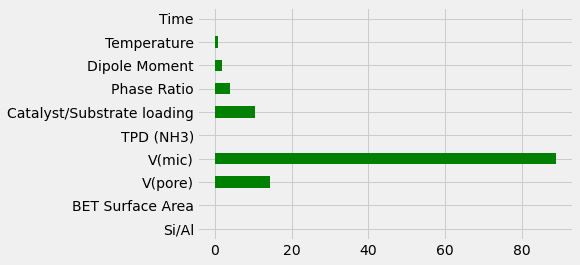

In [ ]:
data = pd.DataFrame([[ 1.65902502e-01], [-3.08626109e-02],  [1.44355836e+01],  [8.88513889e+01],
        [6.40320507e-03],  [1.05728911e+01],  [4.09591890e+00],  [1.99305277e+00],
        [7.51073006e-01],  [1.68708882e-02]],
                    index=['Si/Al', 'BET Surface Area', 'V(pore)', 'V(mic)',
       'TPD (NH3)', 'Catalyst/Substrate loading',
       'Phase Ratio', 'Dipole Moment', 'Temperature',
       'Time'],
                    columns=['values'])
data['values'].plot(kind='barh', color= "g")


## Lasso

In [ ]:
### Grid Search for Lasso
from sklearn.linear_model import Lasso
parameters = {'alpha': np.arange(0.01, 0.9, 0.01)}
clf = GridSearchCV(Lasso(), parameters, scoring='neg_mean_squared_error')
clf.fit(X_train, y_train)
clf.cv_results_['params'][np.argmax(clf.cv_results_['mean_test_score'])]

{'alpha': 0.89}

In [ ]:
# from sklearn.linear_model import Lasso
clf = Lasso(alpha =0.89 )
scores = cross_validate(clf, X_train, y_train, cv=5, scoring=['neg_root_mean_squared_error'])['test_neg_root_mean_squared_error']
np.mean(scores)

-21.082150366336705

## SVR

In [ ]:
from sklearn.svm import SVR
parameters = {'C':np.arange(5,10,1), 'epsilon':np.arange(0.01,0.1,0.02)}
clf = GridSearchCV(SVR(), parameters, scoring='neg_mean_squared_error')
clf.fit(X_train, y_train)
clf.cv_results_['params'][np.argmax(clf.cv_results_['mean_test_score'])]

{'C': 5, 'epsilon': 0.01}

In [ ]:
from sklearn.svm import SVR
clf = SVR(C= 8, epsilon = 0.01)
scores = cross_validate(clf, X_train, y_train, cv=5, scoring=['neg_root_mean_squared_error'])['test_neg_root_mean_squared_error']
np.mean(scores)

-20.166244229648026

In [ ]:
np.std(scores)

1.5030128310841875

## GPR

In [ ]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, DotProduct, RBF
import matplotlib.pyplot as plt
import numpy as np
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

In [ ]:
# Random seeds
np.random.seed(seed=0)  # Set seed for NumPy
random_state = 0
# Instantiate a Gaussian Process model
kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))

gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9, alpha= 0.05)

In [ ]:
# New random forest with only the two most important variables
model = gpr 
X  = features
y = labels
cv = KFold(n_splits=5, random_state=1, shuffle=True)
scores = cross_val_score(model, X, y, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)
# report performance
print('MAE: %.4f (%.4f)' % (np.abs(mean(scores)), np.std(scores)))
#print('accuracy %.3f (%.3f)' % (np.abs(mean(model.score)), std(scores)))

MAE: 30.0882 (4.0803)


# KRR

In [ ]:
from sklearn.kernel_ridge import KernelRidge
clf = KernelRidge(alpha=1.0)
scores = cross_validate(clf, X_train, y_train, cv=5, scoring=['neg_root_mean_squared_error'])['test_neg_root_mean_squared_error']
np.mean(scores)

-38.1699184722158

In [ ]:
np.std(scores)

5.173280076818606

In [ ]:
19.74/80.9

0.24400494437577253

# correlation matrix

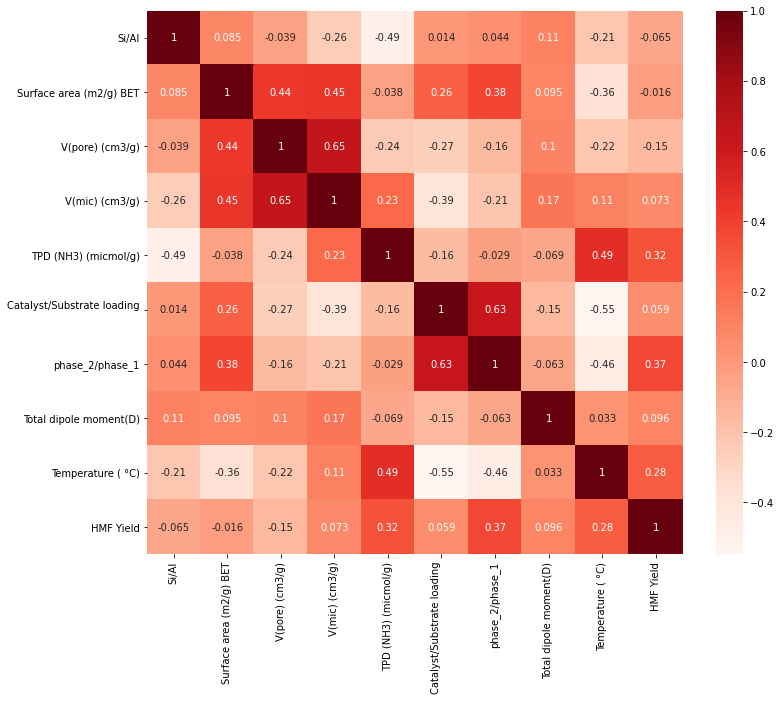

In [ ]:
#Using Pearson Correlation
import seaborn as sns
plt.figure(figsize=(12,10))
cor = df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

# PCA 

In [ ]:

# Machine learning related functions
from sklearn.preprocessing import StandardScaler #normalizing inputs
from sklearn.decomposition import PCA  # principal component analysis
from sklearn.gaussian_process import GaussianProcessRegressor 
from sklearn.preprocessing import StandardScaler


In [ ]:
# Separating out the features
x = df.drop(columns=['HMF Yield'])
# Separating out the target
y = df['HMF Yield']
bins = [-0.00001,25,50,75,100]
labels = ['<25','25-50','50-75','>75']
y = pd.cut(y, bins=bins, labels=labels)
#y =y.cat.codes
#Standardizing the features
x = StandardScaler().fit_transform(x.select_dtypes('float'))

In [ ]:
pca = PCA().fit(x)
# plotting 
evr = np.cumsum(pca.explained_variance_ratio_)
print('{:<20s}{:<80s}'.format('No. of PC', 'Cumulative explained varience'))
print(50*'-')
for i,a in enumerate(evr):
    if a<=1:
        print('{:<20d}{:<80f}'.format(i+1,a))

No. of PC           Cumulative explained varience                                                   
--------------------------------------------------
1                   0.304394                                                                        
2                   0.522251                                                                        
3                   0.678017                                                                        
4                   0.786996                                                                        
5                   0.856405                                                                        
6                   0.914497                                                                        
7                   0.948832                                                                        
8                   0.968979                                                                        
9                   0.988746            

In [ ]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
#principalDf = principalDf.drop(principalDf.index[[41,42,43,44]])
#y = y.drop(y.index[[41,42,43,44]])

In [ ]:
#Removing outliers
import scipy.stats as stats
z_scores = stats.zscore(principalDf)
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 2).all(axis=1)
principalDf = principalDf[filtered_entries]

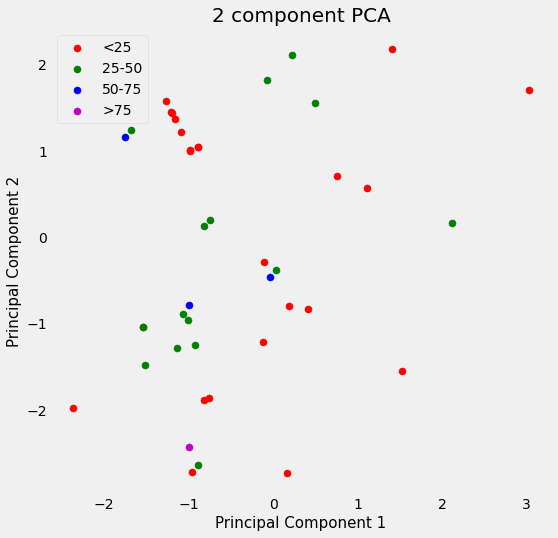

In [ ]:
finalDf = pd.concat([principalDf, y], axis = 1)
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['<25','25-50','50-75','>75']
colors = ['r', 'g', 'b','m']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['HMF Yield']== target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()
images_dir = '/content/gdrive/My Drive'
plt.savefig(f"{images_dir}/pca.png", bbox_inches='tight', dpi = 160)

In [ ]:
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2', 'principal component 3'])

In [ ]:
#Removing outliers
import scipy.stats as stats
z_scores = stats.zscore(principalDf)
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)
principalDf = principalDf[filtered_entries]

In [ ]:
#principalDf = principalDf.drop(principalDf.index[[41,42,43,44,61]])
y = df['HMF Yield']
bins = [-0.00001,25,50,75,100]
labels = ['<25','25-50','50-75','>75']
y = pd.cut(y, bins=bins, labels=labels)
#y= y.drop(y.index[[41,42,43,44,61]])

In [ ]:
y[filtered_entries].shape

(96,)

In [ ]:
finalDf = pd.concat([principalDf,y], axis = 1)

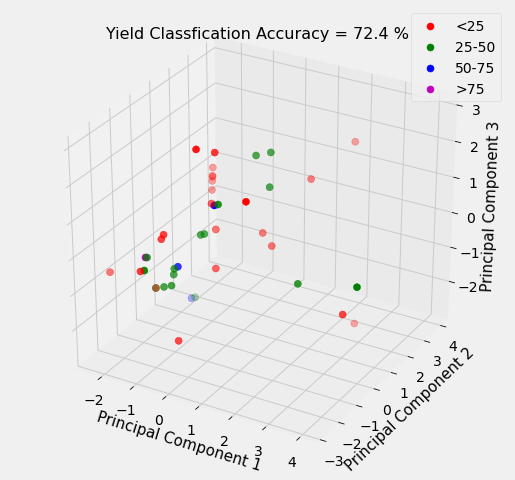

In [ ]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_zlabel('Principal Component 3', fontsize = 15)

ax.set_title('Yield Classfication Accuracy = 72.4 %', fontsize = 16)
targets = ['<25','25-50','50-75','>75']
colors = ['r', 'g', 'b','m']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['HMF Yield']== target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , finalDf.loc[indicesToKeep, 'principal component 3']
               , c = color
               , s = 50)
#ax.text(-4,4,1.5,"Classfication Accuracy = 90 %",fontsize=14)
ax.legend(targets)
#ax.grid()
images_dir = '/content/gdrive/My Drive'
plt.savefig(f"{images_dir}/pca_final.png", bbox_inches='tight', dpi = 160)

In [ ]:
pca = PCA(n_components=7)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2', 'principal component 3','principal component 4','principal component 5','principal component 6','principal component 7'])

In [ ]:
#Removing outliers
import scipy.stats as stats
z_scores = stats.zscore(principalDf)
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)
principalDf = principalDf[filtered_entries]


In [ ]:
#principalDf = principalDf.drop(principalDf.index[[41,42,43,44,61]])
y = df['HMF Yield']
#y = y[filtered_entries]
bins = [-0.00001,25,50,75,100]
labels = ['<25','25-50','50-75','>75']
y = pd.cut(y, bins=bins, labels=labels)
#y= y.drop(y.index[[41,42,43,44,61]])

In [ ]:
#label encoding
y = y.astype('category')
y = y.cat.codes
#y[filtered_entries]

# Classification

In [ ]:
df_2=(df_2-df_2.mean())/df_2.std()
features = df_2[['Si/Al','TPD (NH3) (micmol/g)','phase_2/phase_1', 'Total dipole moment(D)', 'Temperature ( °C)']].values
feature_list = list(df.drop(columns = ['HMF Yield']).columns)
labels = df['HMF Yield'].values

In [ ]:
X = df.drop(columns = ['HMF Yield']).values

In [ ]:
X = features

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.1, random_state=50)

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001]} 
grid = GridSearchCV(SVC(),param_grid,refit=True,verbose=2)
preds = grid.fit(X_train,y_train).predict(X_test)

print('SVM Train accuracy %s' % grid.score(X_train, y_train)) 
print('SVM Test accuracy %s' % accuracy_score(preds, y_test)) 

print(confusion_matrix(y_test, preds)) 
print(classification_report(y_test, preds)) 

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] C=0.1, gamma=1 ..................................................
[CV] ................................... C=0.1, gamma=1, total=   0.0s
[CV] C=0.1, gamma=1 ..................................................
[CV] ................................... C=0.1, gamma=1, total=   0.0s
[CV] C=0.1, gamma=1 ..................................................
[CV] ................................... C=0.1, gamma=1, total=   0.0s
[CV] C=0.1, gamma=1 ..................................................
[CV] ................................... C=0.1, gamma=1, total=   0.0s
[CV] C=0.1, gamma=1 ..................................................
[CV] ................................... C=0.1, gamma=1, total=   0.0s
[CV] C=0.1, gamma=0.1 ................................................
[CV] ................................. C=0.1, gamma=0.1, total=   0.0s
[CV] C=0.1, gamma=0.1 ................................................
[CV] ...........

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ................................ C=100, gamma=0.01, total=   0.0s
[CV] C=100, gamma=0.01 ...............................................
[CV] ................................ C=100, gamma=0.01, total=   0.0s
[CV] C=100, gamma=0.01 ...............................................
[CV] ................................ C=100, gamma=0.01, total=   0.0s
[CV] C=100, gamma=0.001 ..............................................
[CV] ............................... C=100, gamma=0.001, total=   0.0s
[CV] C=100, gamma=0.001 ..............................................
[CV] ............................... C=100, gamma=0.001, total=   0.0s
[CV] C=100, gamma=0.001 ..............................................
[CV] ............................... C=100, gamma=0.001, total=   0.0s
[CV] C=100, gamma=0.001 ..............................................
[CV] ............................... C=100, gamma=0.001, total=   0.0s
[CV] C=100, gamma=0.001 ..............................................
[CV] .

[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:    0.2s finished


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1,random_state=100) 
lr = LogisticRegression(random_state=0)

model = lr.fit(X_train, y_train)
preds = model.predict(X_test)

print('Logistic Regression Train accuracy %s' % model.score(X_train, y_train)) 
print('Logistic Regression Test accuracy %s' % accuracy_score(preds, y_test)) 

print(confusion_matrix(y_test, preds)) 
print(classification_report(y_test, preds)) 

Logistic Regression Train accuracy 0.7471264367816092
Logistic Regression Test accuracy 0.8
[[5 0 0]
 [1 3 0]
 [0 1 0]]
              precision    recall  f1-score   support

           0       0.83      1.00      0.91         5
           1       0.75      0.75      0.75         4
           2       0.00      0.00      0.00         1

    accuracy                           0.80        10
   macro avg       0.53      0.58      0.55        10
weighted avg       0.72      0.80      0.75        10



In [ ]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=15)
preds = model.fit(X_train, y_train).predict(X_test)
print('Forest Train accuracy %s' % model.score(X_train, y_train)) 
print('Trees Test accuracy %s' % accuracy_score(preds, y_test)) 

Forest Train accuracy 0.6436781609195402
Trees Test accuracy 0.6


In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

trees = DecisionTreeClassifier(random_state=0)
forest = RandomForestClassifier(n_estimators=15, random_state=42)
preds_trees = trees.fit(X_train,y_train).predict(X_test)
preds_forest = forest.fit(X_train,y_train).predict(X_test)
print('Trees Train accuracy %s' % model.score(X_train, y_train)) 
print('Forest Train accuracy %s' % model.score(X_train, y_train)) 

print('Trees Test accuracy %s' % accuracy_score(preds_trees, y_test)) 
print('Forest Test accuracy %s' % accuracy_score(preds_forest, y_test)) 

Trees Train accuracy 0.6436781609195402
Forest Train accuracy 0.6436781609195402
Trees Test accuracy 0.6
Forest Test accuracy 0.6


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from sklearn import linear_model, tree, ensemble

In [ ]:
kf =KFold(n_splits=5, shuffle=True, random_state=42)

cnt = 1
# split()  method generate indices to split data into training and test set.
for train_index, test_index in kf.split(X, y):
    print(f'Fold:{cnt}, Train set: {len(train_index)}, Test set:{len(test_index)}')
    cnt += 1

Fold:1, Train set: 77, Test set:20
Fold:2, Train set: 77, Test set:20
Fold:3, Train set: 78, Test set:19
Fold:4, Train set: 78, Test set:19
Fold:5, Train set: 78, Test set:19


In [ ]:
score = cross_val_score(linear_model.LogisticRegression(random_state= 42), X, y, cv= kf, scoring="accuracy")
print(f'Scores for each fold are: {score}')
print(f'Average score: {"{:.2f}".format(score.mean())}')

Scores for each fold are: [0.7        0.5        0.94736842 0.73684211 0.73684211]
Average score: 0.72


In [ ]:
score = cross_val_score(tree.DecisionTreeClassifier(random_state= 42), X, y, cv= kf, scoring="accuracy")
print(f'Scores for each fold are: {score}')
print(f'Average score: {"{:.2f}".format(score.mean())}')

Scores for each fold are: [0.65       0.65       0.63157895 0.78947368 0.63157895]
Average score: 0.67


In [ ]:
score = cross_val_score(ensemble.RandomForestClassifier(random_state= 42), X, y, cv= kf, scoring="accuracy")
print(f'Scores for each fold are: {score}')
print(f'Average score: {"{:.2f}".format(score.mean())}')

Scores for each fold are: [0.65       0.7        0.68421053 0.73684211 0.57894737]
Average score: 0.67


In [ ]:
algorithms = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']

for algo in algorithms:
    score = cross_val_score(linear_model.LogisticRegression(max_iter= 4000, solver= algo, random_state= 42), X, y, cv= kf, scoring="accuracy")
    print(f'Average score({algo}): {"{:.3f}".format(score.mean())}')

Average score(newton-cg): 0.724
Average score(lbfgs): 0.724
Average score(liblinear): 0.724
Average score(sag): 0.724
Average score(saga): 0.724


In [ ]:
max_depth = [1,2,3,4,5,6,7,8,9,10]

for val in max_depth:
    score = cross_val_score(tree.DecisionTreeClassifier(max_depth= val, random_state= 42), X, y, cv= kf, scoring="accuracy")
    print(f'Average score({val}): {"{:.3f}".format(score.mean())}')

Average score(1): 0.743
Average score(2): 0.723
Average score(3): 0.692
Average score(4): 0.681
Average score(5): 0.682
Average score(6): 0.671
Average score(7): 0.681
Average score(8): 0.671
Average score(9): 0.671
Average score(10): 0.671


In [ ]:
n_estimators = [50, 100, 150, 200, 250, 300, 350]

for val in n_estimators:
    score = cross_val_score(ensemble.RandomForestClassifier(n_estimators= val, random_state= 42), X, y, cv= kf, scoring="accuracy")
    print(f'Average score({val}): {"{:.3f}".format(score.mean())}')

Average score(50): 0.670
Average score(100): 0.670
Average score(150): 0.670
Average score(200): 0.681
Average score(250): 0.670
Average score(300): 0.670
Average score(350): 0.659


In [ ]:
from xgboost import XGBClassifier
model = XGBClassifier()
preds = model.fit(X_train, y_train).predict(X_test)
print('Forest Train accuracy %s' % model.score(X_train, y_train)) 
print('Trees Test accuracy %s' % accuracy_score(preds, y_test)) 

Forest Train accuracy 0.9425287356321839
Trees Test accuracy 0.6
